# Metadata, QA, QC

The purpose of this notebook is for ensuring the `precip-dot` dataset meets SNAPs standards for metadata, quality assurance, and quality control. 

In [2]:
import glob, os
import numpy as np
import rasterio as rio
import xarray as xr
from datetime import datetime
from rasterio import warp

# Metadata questionnaire

Timestamp:

In [3]:
print("Created on: {}".format(datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S")))

Created on: 2021-01-08 19:12:27


## Time & place

#### Description of Geographic Extent

All data files contain gridded data making use of the same grid, which covers Alaska and some of the surrounding region.

In [20]:
# determine approximate grid dimensions
out_dir = "/workspace/Shared/Tech_Projects/DOT/project_data/wrf_pcpt/fudgeci"
out_fps = [
    os.path.join(out_dir, fn) 
    for fn in sorted(glob.glob(os.path.join(out_dir, "*")))
]

with rio.open(f"netcdf:{out_fps[0]}:pf") as src:
    width, height = src.width, src.height
    bb = warp.transform_bounds(
        src.crs, 
        rio.crs.CRS.from_epsg(4326),
        *src.bounds
    )
    xres, yres = src.res
    meta = src.meta

#### Place keywords

Alaska, polar

#### Bounding coordinates: 

INCORRECT, NEEDS TO BE FIXED ([this link could help](https://gis.stackexchange.com/questions/301729/get-a-bounding-box-of-a-geometry-that-crosses-the-antimeridian-using-ogr))

see cell below for some investigation

In [11]:
print("Western bound:", round(bb[0], 4))
print("Southern bound:", round(bb[1], 4))
print("Eastern bound:", round(bb[2], 4))
print("Northern bound:", round(bb[3], 4))

Western bound: -178.1631
Southern bound: 49.0572
Eastern bound: 179.8282
Northern bound: 71.4604


In [81]:
# This code demonstrates that the transform_bounds method cannot be used here because 
# of overlap with the antimeridian. 

# This code returns the WGS84 transform of coorindates at various parts of the extent of the projected CRS

wrf_proj = "+proj=stere +lat_0=90 +lat_ts=64 +lon_0=-152 +k=1 +x_0=0 +y_0=0 +a=6370000 +b=6370000 +units=m +no_defs"
src_crs = rio.crs.CRS.from_string(wrf_proj)
dst_crs = rio.crs.CRS.from_epsg(4326)

# upper left
warp.transform(src_crs, dst_crs, [0], [bounds[3]])
# lower left
warp.transform(src_crs, dst_crs, [bounds[0]], [bounds[1]])
# lower right
warp.transform(src_crs, dst_crs, [bounds[2]], [bounds[1]])
# upper right
warp.transform(src_crs, dst_crs, [bounds[2]], [bounds[3]])
# upper middle
warp.transform(src_crs, dst_crs, [0], [bounds[3]])
# lower middle
warp.transform(src_crs, dst_crs, [0], [bounds[1]])


# below provides the extent of the underlying WRF grid
# THESE ARE THE CORRECT BOUNDS, BUT NOT DERIVED FROM FINAL DATA
wrf_fp = "/workspace/Shared/Tech_Projects/wrf_data/project_data/wind-issue/truth_winds_1980-01-01_00.nc"

with xr.open_dataset(wrf_fp) as ds:
    lons = ds.lon.values
    lats = ds.lat.values

# Western extent is past antimeridian (180)
print(f"Western bound: {lons.max()}")
print(f"Southern bound: {lats.min()}")
print(f"Eastern bound: {lons[lons < 0].max()}")
print(f"Northern bound: {lats.max()}")

Western bound: 179.99908447265625
Southern bound: 37.23276901245117
Eastern bound: -65.9981689453125
Northern bound: 88.26934051513672


Grid:

In [19]:
print(f"Resolution: {round(xres)} m")
print(f"Width: {width}, Height: {height}")

Resolution: 482 m
Width: 7639, Height: 4110


In [92]:
import os, glob, datetime
import numpy as np
import pandas as pd
import rasterio as rio
import xarray as xr
from osgeo import gdal
from rasterio.crs import CRS
from rasterio.plot import show
from rasterio.warp import transform_bounds

#### Time period

Data are not strictly temporally referenced. Instead, they represent probabilistic representations of projections for three future time periods: 2020-2049, 2050-2079, and 2080-2099.

## Origins

### Info

#### Who created the data? 
Cameron Tauxe (Neptune, Inc); Bob Torgerson, Kyle Redilla (SNAP)

#### Who owns the data?
Alaska Department of Transportation (AK DOT)

#### Email
rltorgerson@alaska.edu

#### Address
2158 Koyukuk St, Fairbanks, AK 99709

### Credit

#### Other organizations who should get credit?
Underlying data development led by Peter Bieniek with CASC support

## About

#### Abstract

Annual maximum series-based precipitation frequency estimates with 90% confidence intervals for Alaska derived from WRF-downscaled reanlaysis (ERA-Interim) and CMIP5 GCM (GFDL-CM3, NCAR-CCSM4) precipitation data. Estimates and confidence intervals are based on exceedance probabilities and durations used in the NOAA Atlas 14 study. Projections are present for three future time periods: 2020-2049, 2050-2079, and 2080-2099.

#### Keywords

Alaska, WRF, GFDL-CM3, NCAR-CCSM4, precipitation, projections

#### Purpose

Developed for the Alaska Department of Transportation to inform infrastructure planning.

#### File format

NetCDF

#### License

These data are not currently available for public use. 

#### Cross reference

TBD

## Methods

#### Protocols / methods used

The methods used for developing estimates are closely based upon Perica et al. 2012. A "delta method" (Villegas and Jarvis, 2010) was used to downscale the projected changes and estimates to the finer resolution grid used in the NOAA Atlas 14 study. 

#### Analytical tools

The codebase for developing these data is written in Python and it makes use of popular statistical and geospatial packages and libraries. 

#### References

Villegas, J.R. and Jarvis, A. (2010) Downscaling Global Circulation Model Outputs: The Delta Method. Decision and Policy Analysis Working Paper No. 1, Centro Internacional de Agricultura Tropical.

Sanja Perica, Douglas Kane, Sarah Dietz, Kazungu Maitaria, Deborah Martin, Sandra Pavlovic, Ishani Roy, Svetlana Stuefer, Amy Tidwell, Carl Trypaluk, Dale Unruh, Michael Yekta, Erica Betts, Geoffrey Bonnin, Sarah Heim, Lillian Hiner, Elizabeth Lilly, Jayashree Narayanan, Fenglin Yan, Tan Zhao (2012). NOAA Atlas 14 Volume 7 Version 2.0, Precipitation-Frequency Atlas of the United States, Alaska. NOAA, National Weather Service, Silver Spring, MD.

#### Processing steps

The complete data processing is done by the code in the `pipeline/` directory of this repository: https://github.com/ua-snap/precip-dot. A high-level overview of the processing steps is given in the README.

#### Base data

Downscaled GCM and Reanalysis data made available by SNAP: http://ckan.snap.uaf.edu/dataset/historical-and-projected-dynamically-downscaled-climate-data-for-the-state-of-alaska-and-surrou

NOAA Atlas 14 data made available by NOAA: https://hdsc.nws.noaa.gov/hdsc/pfds/pfds_map_ak.html

## Data

#### Entity

The NetCDF data files are all structured identically. Each have three dimensions and three data variables. The data variables are "pf", "pf_upper", and "pf_lower", corresponding to the precipitation estimate, upper, and lower bounds of 90% confidence intervals, respectively. The duration and GCM source of the underlying data being represneted is given in the filename.

The coordinate variables (and dimension names) are "xc", "yc", and "interval". These variables correspond to the x and y coordinate in EPSG:3338, and the reciprocal of the annual exceedance probability in years.

In [85]:
fp = out_fps[0]
with xr.open_dataset(fp) as ds:
    print(f"\n  Data variable atributes for {fp}:\n")
    print(ds[list(ds.variables)[0]])


  Data variable atributes for /workspace/Shared/Tech_Projects/DOT/project_data/wrf_pcpt/fudgeci/pcpt_NCAR-CCSM4_sum_wrf_10d_2020-2049_fudgeci.nc:

<xarray.DataArray 'pf' (interval: 9, yc: 4110, xc: 7639)>
[282566610 values with dtype=float32]
Coordinates:
  * xc        (xc) float64 -2.176e+06 -2.176e+06 ... 1.501e+06 1.502e+06
  * yc        (yc) float64 2.384e+06 2.384e+06 2.383e+06 ... 4.06e+05 4.055e+05
  * interval  (interval) float64 2.0 5.0 10.0 25.0 50.0 100.0 200.0 500.0 1e+03
Attributes:
    long_name:     AMS-based precipitation frequency estimates
    units:         1/1000 inches
    grid_mapping:  crs


#### Spatial reference

The coordinate reference system used is EPSG:3338. The spatial attributes are saved within the dummy variable called "crs":

In [86]:
with xr.open_dataset(fp) as ds:
    print(f"\n  Coordinate Reference System for {fp}:\n")
    print(ds.crs)


  Coordinate Reference System for /workspace/Shared/Tech_Projects/DOT/project_data/wrf_pcpt/fudgeci/pcpt_NCAR-CCSM4_sum_wrf_10d_2020-2049_fudgeci.nc:

<xarray.DataArray 'crs' ()>
array(0)
Attributes:
    crs_wkt:                        PROJCRS["NAD83 / Alaska Albers",BASEGEOGC...
    semi_major_axis:                6378137.0
    semi_minor_axis:                6356752.314140356
    inverse_flattening:             298.257222101
    reference_ellipsoid_name:       GRS 1980
    longitude_of_prime_meridian:    0.0
    prime_meridian_name:            Greenwich
    geographic_crs_name:            NAD83
    horizontal_datum_name:          North American Datum 1983
    projected_crs_name:             NAD83 / Alaska Albers
    grid_mapping_name:              albers_conical_equal_area
    standard_parallel:              [55. 65.]
    latitude_of_projection_origin:  50.0
    longitude_of_central_meridian:  -154.0
    false_easting:                  0.0
    false_northing:                 0.0


#### Attributes

Other metadata are provided as global attributes in the NetCDF files:

In [87]:
with xr.open_dataset(fp) as ds:
    print(f"  Global attributes for {fp}:\n")
    _ = [print(k, ds.attrs[k]) for k in ds.attrs]

  Global attributes for /workspace/Shared/Tech_Projects/DOT/project_data/wrf_pcpt/fudgeci/pcpt_NCAR-CCSM4_sum_wrf_10d_2020-2049_fudgeci.nc:

Conventions CF-1.8
institution Scenarios Network for Alaska + Arctic Planning
contact kmredilla@alaska.edu
history 2021-01-08 16:39:42.474983 Python
comment Intended for use by Alaska Department of Transportation
source_gcm NCAR-CCSM4
source_timerange 2020-2049


## Quality Assurance

Demonstrate functionality and performance across common platforms, tools and services.

### GDAL

Using the ‘gdalinfo <file>’ function from command line, the file is readable and displays the file header information about the file dimensions, variables, and metadata. The Open and GetMetadata functions return non-empty values that correspond to the netCDF file contents. The GetProjection function (of the appropriate file) returns a non-empty result corresponding to the data coordinate reference system information.

Here we use the Python GDAL bindings insted of the GDAL CLI.

In [88]:
def test_gdal(fp):
    dataset = gdal.Open(fp, gdal.GA_ReadOnly)
    
    if dataset is not None:
        print("GDALOpen successful.")
    else:
        exit(f"GDALOpen failed for {fp}")
    
    print("Driver: {}/{}".format(dataset.GetDriver().ShortName,
                                dataset.GetDriver().LongName))
    print("Size is {} x {} x {}".format(dataset.RasterXSize,
                                        dataset.RasterYSize,
                                        dataset.RasterCount))
    
    projection = dataset.GetProjection()
    if projection is not None:
        print(f"\nGetProjection successful: \n{projection}")
    else:
        exit(f"GetProjection failed for {fp}")
        
    geotransform = dataset.GetGeoTransform()
    if geotransform:
        print("\nOrigin = ({}, {})".format(geotransform[0], geotransform[3]))
        print("Pixel Size = ({}, {})".format(geotransform[1], geotransform[5]))
    
    metadata = dataset.GetMetadata()
    if metadata is not None:
        print("\nGetMetadata successful")
    else:
        exit(f"GetMetadata failed for {fp}")

In [95]:
test_gdal(f"netcdf:{fp}:pf")

GDALOpen successful.
Driver: netCDF/Network Common Data Format
Size is 7639 x 4110 x 9

GetProjection successful: 
PROJCS["unnamed",GEOGCS["unknown",DATUM["unnamed",SPHEROID["Spheroid",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",50],PARAMETER["longitude_of_center",-154],PARAMETER["standard_parallel_1",55],PARAMETER["standard_parallel_2",65],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]

Origin = (-2176652.08815013, 2384357.9149669986)
Pixel Size = (481.5495420366301, -481.5329500512789)

GetMetadata successful


### Python

Files open with `xarray` and `rasterio`. See examples in `/tests` for more checks.

### Plots, summaries, other validation.

These dat ahave been thoroughly tested, see examples in `/tests`.

## Quality Control

### File headers

Files mostly adhere to Climate Forecasting convention. Given these data are for internal use, strict validation of CF convention adherence is not required.

### Missing data

Data was removed due to limitation of what was available in the NOAA Atlas 14 data. Below validates that these missing data are the same for a random subsample of the files:

In [99]:
# all WRF output files

# iterate through all time slices and find missing data indices, test all equal
arr = np.concatenate([
    xr.load_dataset(fp).pf.values 
    for fp in [out_fps[i] for i in [0,11,21,5]]
])
# iterate to compare all arrays
iterator = iter([np.where(np.isnan(sl)) for sl in arr])
first = next(iterator)
result = all(np.array_equal(first, rest) for rest in iterator)

print("Missing data is consistent across all files: ", result)

Missing data is consistent across all files:  True


### Consistent null values

NaN was used for the missing data / null values. See `/tests/sanity_check.ipynb` for validation.

### Geospatial reference check

Plot a single georeferenced time slice.

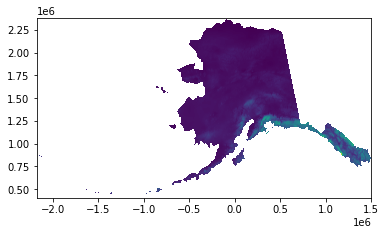

In [100]:
with rio.open(f"netcdf:{fp}:pf") as src:
    show(src.read(1), transform=src.transform)

### Outliers and value errors

See "Consistent null values" section above. All values appear within reasonable range. See `tests/` for more checks.

### Threshold exceedances

See "Consistent null values" section above. All values appear within reasonable range. See `tests/` for more checks.